In [ ]:
import torch
import torch.fft

# Checked
def generate_wavevector(shape):
    # Make wave-vector grid, torch.fft.fftfreq is like linspace for frequencies
    freq_mesh = torch.meshgrid(*[torch.fft.fftfreq(dim) for dim in shape], indexing='ij')
    return torch.stack(freq_mesh, dim=-1) # = k(x) (position inputs --> k freqs outputs)
    
# Checked
# TODO: set the output vector velocity component for time=1 (how?)
def generate_divergence_free_initial_condition(in_shape, device='cuda'):
    torch.manual_seed(0)
    
    # Adding an additional dimension for velocity components
    out_dim = len(in_shape) # number of coordinates == dimensionality of the space
    h = torch.randn(*in_shape, out_dim, device=device)
    # h(x)=out_vec in R^out_dim ('array-func' inputs are indices)
    
    k = generate_wavevector(in_shape).to(device) # k(x) (position inputs --> k freqs outputs)
    k_square = torch.sum(k**2, dim=-1, keepdim=True) # = ||k||^2_2

    # FFT all but the output/range dim (last)
    h_hat = torch.fft.fftn(h, dim=list(range(len(in_shape))))
    k_dot_h = torch.sum(k * h_hat, dim=-1, keepdim=True) # compute h_hat*k
    u0_hat = h_hat - (k_dot_h * k / (k_square + 1e-12)) # subtract proj (make orthog)
    return u0_hat

# Checked
def compute_nonlinear_term(u_hat):
    not_last_dim = list(range(len(u_hat.shape)-1)) # no syntax sugar :(
    u = torch.fft.ifftn(u_hat, dim=not_last_dim)
    nonlinear_term = torch.tensordot(u, u, dims=0) # := u ⊗ u (i.e. tensor product)
    nonlinear_term_hat = torch.fft.fftn(nonlinear_term, dim=not_last_dim)
    return nonlinear_term_hat

def update_velocity(u_hat, nonlinear_term_hat, dt, k_square, k):
    """
    Updates the velocity field in spectral space.

    Args:
        u_hat (torch.Tensor): The Fourier-transformed velocity field.
        nonlinear_term_hat (torch.Tensor): The non-linear term in spectral space.
        dt (float): The time step.
        k_square (torch.Tensor): The square of the wavevector magnitude.
        k (torch.Tensor): The wavevector tensor.
        device (torch.device): The device to use for tensor operations.

    Returns:
        torch.Tensor: The updated velocity field in spectral space.
    """
    k = k.unsqueeze(-2)  # Add the necessary dimension for correct broadcasting
    k_square = k_square.unsqueeze(-2)
    k_dot_u = torch.sum(k * u_hat, dim=-1, keepdim=True)
    k_outer_u = (k_dot_u * k / (k_square + 1e-12))
    diffusion_term = -k_square * u_hat

    u_hat_new = u_hat + dt * (nonlinear_term_hat - k_outer_u + diffusion_term)
    return u_hat_new

def simulate_navier_stokes(shape, num_steps, dt, device):
    """
    Simulates the Navier-Stokes equations using the Fourier pseudo-spectral method.

    Args:
        shape (tuple): The shape of the domain.
        num_steps (int): The number of time steps.
        dt (float): The time step.
        device (torch.device): The device to use for tensor operations.

    Returns:
        torch.Tensor: The final velocity field in spectral space.
    """
    u_hat = generate_divergence_free_initial_condition(shape, device)
    k = generate_wavevector(shape, device)
    k_square = torch.sum(k**2, dim=-1, keepdim=True).to(device)

    for _ in range(num_steps):
        nonlinear_term_hat = compute_nonlinear_term(u_hat, shape, device)
        u_hat = update_velocity(u_hat, nonlinear_term_hat, dt, k_square, k, device)

    return u_hat

# Simulation parameters
shape = (128, 128, 64)  # Example for 3D, change as needed
num_steps = 100
dt = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run the simulation
u_hat = simulate_navier_stokes(shape, num_steps, dt, device)

# Transform back to physical space to get the velocity field
u = torch.fft.ifftn(u_hat, dim=range(len(shape))).real

# Print the resulting velocity field
print(u.shape)

## Divergence Free IC (Eq. 3):
$ \bar u_0(k) = \bar h(k) - {k(k*\bar h(k)) \over ||k||^2_2} $ \
$ \nabla * u_0 = \sum_j^3 {du_0 \over dx_j}$ \
$ F(\nabla * u_0) = \sum_j^3 ik_j*\bar u_0 = ik*\bar u_0$ \
$ \nabla * \bar u_0 = 0 \implies k*u_0=0 $

In [ ]:
# returns frequencies found at each corresponding location in the FFT output (for given size)
torch.fft.fftfreq(5)

In [ ]:
# Checked
def generate_wavevector(shape):
    # Make wave-vector grid, torch.fft.fftfreq is like linspace for frequencies
    freq_mesh = torch.meshgrid(*[torch.fft.fftfreq(dim) for dim in shape], indexing='ij')
    return torch.stack(freq_mesh, dim=-1) # = k(x) (position inputs --> k freqs outputs)
    
# Checked
# TODO: set the output vector velocity component for time=1 (how?)
def generate_divergence_free_initial_condition(in_shape, device='cuda'):
    torch.manual_seed(0)
    
    # Adding an additional dimension for velocity components
    out_dim = len(in_shape) # number of coordinates == dimensionality of the space
    h = torch.randn(*in_shape, out_dim, device=device)
    # h(x)=out_vec in R^out_dim ('array-func' inputs are indices)
    
    k = generate_wavevector(in_shape).to(device) # k(x) (position inputs --> k freqs outputs)
    k_square = torch.sum(k**2, dim=-1, keepdim=True) # = ||k||^2_2

    # FFT all but the output/range dim (last)
    h_hat = torch.fft.fftn(h, dim=list(range(len(in_shape))))
    k_dot_h = torch.sum(k * h_hat, dim=-1, keepdim=True) # compute h_hat*k
    u0_hat = h_hat - (k_dot_h * k / (k_square + 1e-12)) # subtract proj (make orthog)
    return u0_hat

In [ ]:
u0_hat = generate_divergence_free_initial_condition([2,2])
u0_hat.shape

In [ ]:
u0_hat[1,1]

## Non-linear (quadratic) term:
$ \overline { u^n \otimes u^n } = F(F^{-1}(\bar u^n)\otimes F^{-1}(\bar u^n)) $

In [ ]:
# Checked
# TODO: fix enormous OOM issue!
def compute_nonlinear_term(u_hat):
    not_last_dim = list(range(len(u_hat.shape)-1)) # no syntax sugar :(
    u = torch.fft.ifftn(u_hat, dim=not_last_dim)
    nonlinear_term = torch.tensordot(u, u, dims=0) # := u ⊗ u (i.e. tensor product)
    nonlinear_term_hat = torch.fft.fftn(nonlinear_term, dim=not_last_dim)
    return nonlinear_term_hat

## Forward equation:
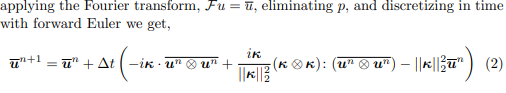

In [ ]:
def update_velocity(u_hat, dt, k_square, k):
    """
    Updates the velocity field in spectral space.

    Args:
        u_hat (torch.Tensor): The Fourier-transformed velocity field.
        dt (float): The time step.
        k_square (torch.Tensor): The square of the wavevector magnitude.
        k (torch.Tensor): The wavevector tensor.
    Returns:
        torch.Tensor: The updated velocity field in spectral space.
    """
    # TODO: Fix this crazy term taking 73 TBs of memory!!!
    nonlinear_term_hat = compute_nonlinear_term(u_hat)
    k_outer_k = torch.tensordot(k, k, dims=0) # outer product
    k_outer_u = torch.tensordot(k_outer_k, nonlinear_term_hat) # inner product
    k_outer_u = (1j*k / (k_square + 1e-12))*k_outer_u
    
    #k_dot_u = torch.sum(k * u_hat, dim=-1, keepdim=True) # suss, or maybe more efficient??
    #k_outer_u = (k_dot_u * ij*k / (k_square + 1e-12)) # suss
    diffusion_term = -k_square * u_hat # good

    u_hat_new = u_hat + dt * (-1j*k*nonlinear_term_hat - k_outer_u + diffusion_term)
    return u_hat_new

In [ ]:
def simulate_navier_stokes(shape, num_steps, dt, device):
    """
    Simulates the Navier-Stokes equations using the Fourier pseudo-spectral method.

    Args:
        shape (tuple): The shape of the domain.
        num_steps (int): The number of time steps.
        dt (float): The time step.
        device (torch.device): The device to use for tensor operations.

    Returns:
        torch.Tensor: The final velocity field in spectral space.
    """
    u_hat = generate_divergence_free_initial_condition(shape, device)
    k = generate_wavevector(shape).to(device)
    k_square = torch.sum(k**2, dim=-1, keepdim=True)

    for _ in range(num_steps):
        u_hat = update_velocity(u_hat, dt, k_square, k)

    return u_hat

In [ ]:
# Simulation parameters
shape = (32, 32, 16)  # Example for 3D, change as needed
num_steps = 100
dt = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run the simulation
u_hat = simulate_navier_stokes(shape, num_steps, dt, device)

# Transform back to physical space to get the velocity field
u = torch.fft.ifftn(u_hat, dim=range(len(shape))).real

# Print the resulting velocity field
print(u.shape)

In [ ]:
K = torch.tensordot(u,u, dims=0)
print(K.shape)

lin_coords = [torch.arange(d) for d in u.shape]*2
mesh = torch.meshgrid(*[torch.arange(d) for d in u.shape]*2, indexing='ij')
flat_mesh = [grid_i.ravel() for grid_i in mesh]

assert (K[flat_mesh]==u[flat_mesh[:2]]*u[flat_mesh[2:]]).all()

In [ ]:
u_hat